Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    TimeSeriesTransformerConfig,
    TimeSeriesTransformerForPrediction,
)
from gluonts.time_feature import (
    get_lags_for_frequency,
    time_features_from_frequency_str,
)
from gluonts.dataset.pandas import PandasDataset
from gluonts.itertools import Map
from datasets import Dataset, DatasetDict, Features, Value, Sequence
from functools import lru_cache, partial
from gluonts.dataset.field_names import FieldName

from accelerate import Accelerator
from torch.optim import AdamW
import matplotlib.dates as mdates
import sys
from pathlib import Path

# Get the parent directory
parent_dir = Path.cwd().parent.parent

# Ensure it's not already in sys.path
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.transformer import create_train_dataloader, create_test_dataloader, transform_start_field, TransformerModel

Load dataset and prepare df

In [3]:
file_path = "../data/parsed_dataset.csv"
date_column = "period"
target_column = "value"
id_column = "item_id"

df = pd.read_csv(file_path, parse_dates=[date_column])[[date_column, target_column]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()

df[id_column] = "id"
df[target_column] = df[target_column].fillna(0)
df.set_index(date_column, inplace=True)

unique_dates = df.index.unique()

Train, validation, test split

In [4]:
df_train = df[df.index < unique_dates[-int(len(unique_dates) *0.8)]]
df_validation = df[df.index < unique_dates[-int(len(unique_dates) *0.9)]]
df_test = df

Process fields for dataset

In [5]:
class ProcessStartField:
    ts_id = 0

    def __call__(self, data):
        data["start"] = data["start"].to_timestamp()
        data["feat_static_cat"] = [self.ts_id]
        data["feat_dynamic_real"] = None
        # data["item_id"] = f"T{self.ts_id+1}"
        self.ts_id += 1

        return data

Features for dataset

In [6]:
features = Features(
    {
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float32")),
        "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
        "item_id": Value("string"),
    }
)

Create datasets from data frames

In [7]:
ds_train = PandasDataset.from_long_dataframe(
    df_train, target=target_column, item_id=id_column
)
ds_validation = PandasDataset.from_long_dataframe(
    df_validation, target=target_column, item_id=id_column
)
ds_test = PandasDataset.from_long_dataframe(
    df_test, target=target_column, item_id=id_column
)

process_start = ProcessStartField()
process_start.ts_id = 0
list_ds_train = list(Map(process_start, ds_train))
process_start.ts_id = 0
list_ds_validation = list(Map(process_start, ds_validation))
process_start.ts_id = 0
list_ds_test = list(Map(process_start, ds_test))

train_dataset = Dataset.from_list(list_ds_train, features=features)
validation_dataset = Dataset.from_list(list_ds_validation, features=features)
test_dataset = Dataset.from_list(list_ds_test, features=features)

dataset = DatasetDict(
    {"train": train_dataset, "validation": validation_dataset, "test": test_dataset}
)

In [8]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [9]:
freq = "H"
prediction_length = int(len(unique_dates) *0.01)

In [10]:
prediction_length

114

In [11]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [12]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


In [13]:
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function hour_of_day at 0x72db6ab45ab0>, <function day_of_week at 0x72db6ab45bd0>, <function day_of_month at 0x72db6ab45cf0>, <function day_of_year at 0x72db6ab45e10>]


In [14]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age"):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each one of the possible values:
    embedding_dimension=[2],
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [15]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=32,
    num_batches_per_epoch=1,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=8
)

In [16]:
accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())


{'weight': Parameter containing:
tensor([[-0.0016, -0.0094]], requires_grad=True), 'input': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'padding_idx': -1, 'scale_grad_by_freq': False, 'sparse': False}
{'weight': Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.5332,  0.3110,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9021,  0.5911,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.2879,  0.8433,  0.3775,  ...,  0.9819,  0.9943,  0.9982],
        [ 0.6503,  0.4269,  0.6467,  ...,  0.9818,  0.9942,  0.9982],
        [ 0.9906, -0.1209,  0.8519,  ...,  0.9817,  0.9942,  0.9982]]), 'input': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43, 

In [17]:
model.eval()

TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesMeanScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(1, 2)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=49, out_features=32, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(342, 32)
      (layers): ModuleList(
        (0-3): 4 x TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, elementw

In [18]:
accelerator = Accelerator()
device = accelerator.device

total = 0
all_forecasts = []
while True:
    forecasts = []
    
    for index, batch in enumerate(test_dataloader):
        # raise KeyError(batch)
        outputs = model.generate(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
        )
        forecasts.append(outputs.sequences.cpu().numpy())
    forecasts = np.vstack(forecasts)
    forecast_median = np.median(forecasts, 1)
    all_forecasts.extend(forecast_median[0])
    total += int(len(unique_dates) *0.01)
    if total >= int(len(unique_dates) *0.1):
        break

{'weight': Parameter containing:
tensor([[-0.0167, -0.0195]], requires_grad=True), 'input': tensor([0]), 'padding_idx': -1, 'scale_grad_by_freq': False, 'sparse': False}
{'weight': Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.5332,  0.3110,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9021,  0.5911,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.2879,  0.8433,  0.3775,  ...,  0.9819,  0.9943,  0.9982],
        [ 0.6503,  0.4269,  0.6467,  ...,  0.9818,  0.9942,  0.9982],
        [ 0.9906, -0.1209,  0.8519,  ...,  0.9817,  0.9942,  0.9982]]), 'input': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62

In [20]:
non_zero = []
 
for i in all_forecasts:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

In [21]:
non_zero = non_zero[:int(len(unique_dates) *0.1)]

In [27]:

ground_truth = np.array(test_dataset[0]["target"][-int(len(unique_dates) *0.1):])
print_evaluation_metrics(non_zero, ground_truth-1, df_train[target_column]-1)

Evaluation Metrics:
MSE: 1222120183.32
RMSE: 34958.84
MAE: 28590.01
MAPE: 10.75
SMAPE: 11.11
MASE: 5.07


In [23]:
def plot(ts_index):
    fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
    

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    #

    ax.plot(
        index[-int(len(unique_dates) *0.1):],
        (np.array(test_dataset[ts_index]["target"][-int(len(unique_dates) *0.1):])-1),
        label="actual",
    )

    ax.plot(
        index[-int(len(unique_dates) *0.1):],
        np.median([non_zero], axis=0),
        label="prediction",
    )

   
    ax.set_title("Prediction Transformer")
    ax.set_ylabel("New Deaths")
    ax.set_xlabel(date_column)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.show()

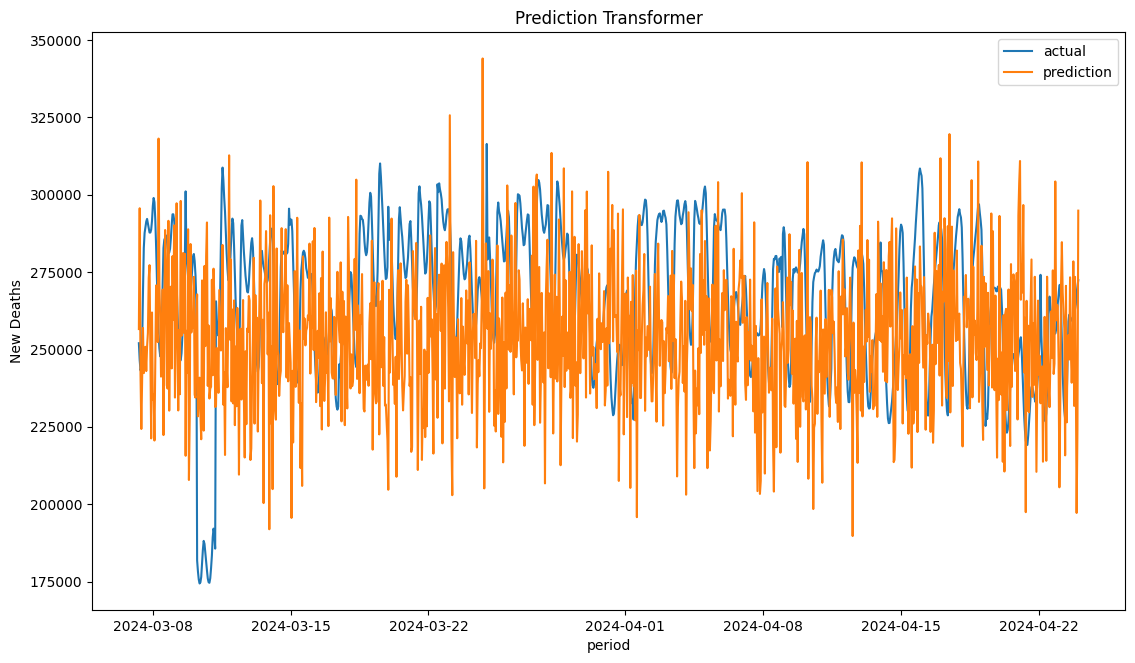

In [24]:
plot(0)

In [16]:
from shared.helpers import load_model
t_model = load_model("transformer")
model = t_model.model

Loading model_part1 in folder ../stored_models/transformer
Object loaded successfully.


In [27]:
class TransformerModel:

    def __init__(self, model, config, target_column, id_column, frequency="D"):
        self.model = model
        self.config = config
        self.frequency = frequency
        self.target_column = target_column
        self.id_column = id_column
        print("Model loaded successfully")

    def predict(self, data):
        accelerator = Accelerator()
        device = accelerator.device
        ds_test = PandasDataset.from_long_dataframe(
            data, target=self.target_column, item_id=self.id_column
        )
        process_start = ProcessStartField()
        process_start.ts_id = 0
        list_ds_test = list(Map(process_start, ds_test))
        test_dataset = Dataset.from_list(list_ds_test, features=features)
        test_dataset.set_transform(partial(transform_start_field, freq=self.frequency))
        
        test_dataloader = create_test_dataloader(
            config=self.config,
            freq=self.frequency,
            data=test_dataset,
            batch_size=8,
        )
        total = 0
        all_forecasts = []
        while True:
            forecasts = []
            
            for index, batch in enumerate(test_dataloader):
                print(batch)
                print("asdasdasdadasdsada")
                outputs = self.model.generate(
                    static_categorical_features=batch["static_categorical_features"].to(device)
                    if self.config.num_static_categorical_features > 0
                    else None,
                    static_real_features=batch["static_real_features"].to(device)
                    if self.config.num_static_real_features > 0
                    else None,
                    past_time_features=batch["past_time_features"].to(device),
                    past_values=batch["past_values"].to(device),
                    future_time_features=batch["future_time_features"].to(device),
                    past_observed_mask=batch["past_observed_mask"].to(device),
                )
                forecasts.append(outputs.sequences.cpu().numpy())
            forecasts = np.vstack(forecasts)
            forecast_median = np.median(forecasts, 1)
            all_forecasts.extend(forecast_median[0])
            total += len(forecast_median[0])
            if total >= len(data):
                break

        return all_forecasts

In [29]:
model_class = TransformerModel(model, config, target_column, id_column, "H")
store_model(model_class, "transformer")

Model loaded successfully
